## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/)) <b><font size='3ptx'>[Generative Adversarial Networks](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/), or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.</font></b>

Developing a GAN for generating images requires both a discriminator convolutional neural network model for classifying whether a given image is real or generated and a generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. **A good starting point for beginners is to practice developing and using GANs on standard image datasets used in the field of computer vision, such as the [MNIST handwritten digit dataset](https://www.kaggle.com/code/ngbolin/mnist-dataset-digit-recognizer/data)**. Using small and well-understood datasets means that smaller models can be developed and trained quickly, allowing the focus to be put on the model architecture and image generation process itself.

**In this tutorial, you will discover how to develop a generative adversarial network with deep convolutional networks for generating handwritten digits.** After completing this tutorial, you will know:
* How to define and train the standalone discriminator model for learning the difference between real and fake images.
* How to define the standalone generator model and train the composite generator and discriminator model.
* How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.

<a id='sect0'></a>
### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into seven parts; they are:
* <font size='3ptx'><b><a href='#sect1'>MNIST Handwritten Digit Dataset</a></b></font>
* <font size='3ptx'><b><a href='#sect2'>How to Define and Train the Discriminator Model</a></b></font>
* <font size='3ptx'><b><a href='#sect3'>How to Define and Use the Generator Model</a></b></font>
* <font size='3ptx'><b><a href='#sect4'>How to Train the Generator Model</a></b></font>
* <font size='3ptx'><b><a href='#sect5'>How to Evaluate GAN Model Performance</a></b></font>
* <font size='3ptx'><b><a href='#sect6'>Complete Example of GAN for MNIST</a></b></font>
* <font size='3ptx'><b><a href='#sect7'>How to Use the Final Generator Model to Generate Images</a></b></font>

In [1]:
from keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
import numpy as np

# example of defining the discriminator model
from keras.models import Sequential
from keras.models import load_model
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

from keras.utils.vis_utils import plot_model

# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy import vstack
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy import asarray

2022-12-05 00:40:17.755827: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-05 00:40:18.296842: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-05 00:40:18.296924: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-05 00:40:20.131535: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

<a id='sect1'></a>
## <font color='darkblue'>MNIST Handwritten Digit Dataset</font>
<font size='3ptx'><b>The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is an acronym that stands for the Modified National Institute of Standards and Technology dataset.</b></font>

It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9. The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

Keras provides access to the MNIST dataset via the [mnist.load_dataset()](https://keras.io/datasets/#mnist-database-of-handwritten-digits) function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

The example below loads the dataset and summarizes the shape of the loaded dataset.

<b><font color='darkred'>Note</font></b>: the first time you load the dataset, Keras will automatically download a compressed version of the images and save them under your home directory in <font color='olive'>~/.keras/datasets/</font>. The download is fast as the dataset is only about eleven megabytes in its compressed form.

In [2]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


Running the example loads the dataset and prints the shape of the input and output components of the train and test splits of images.

<b>We can see that there are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels.</b>

The images are grayscale with a black background (<font color='brown'>0 pixel value</font>) and the handwritten digits in white (<font color='brown'>pixel values near 255</font>). This means if the images were plotted, they would be mostly black with a white digit in the middle.

We can plot some of the images from the training dataset using the matplotlib library using the [imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function and specify the color map via the ‘cmap‘ argument as ‘gray‘ to show the pixel values correctly.

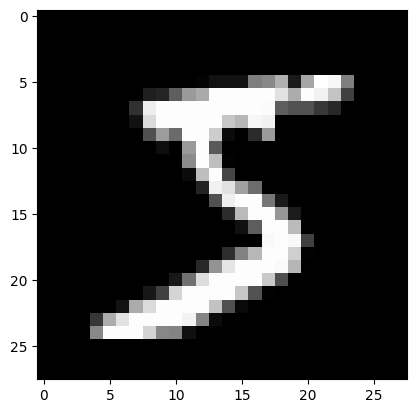

In [3]:
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray')

Alternately, the images are <b>easier to review when we reverse the colors and plot the background as white and the handwritten digits in black</b>. They are easier to view as most of the image is now white with the area of interest in black. This can be achieved using a reverse grayscale color map, as follows:

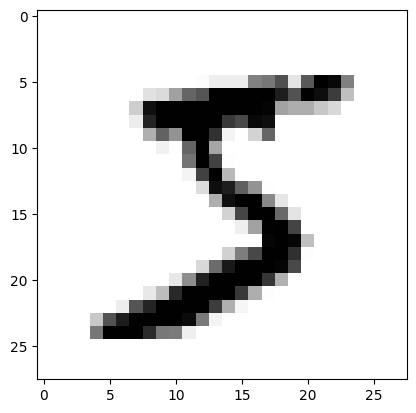

In [4]:
# plot raw pixel data
plt.imshow(trainX[0], cmap='gray_r')

The example below plots the first 25 images from the training dataset in a 5 by 5 square:

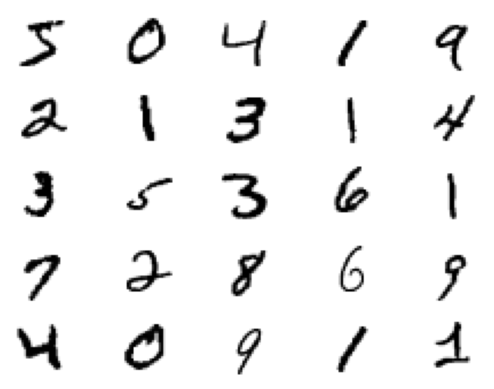

In [5]:
for i in range(25):
  # define subplot
  plt.subplot(5, 5, 1 + i)
  # turn off axis
  plt.axis('off')
  # plot raw pixel data
  plt.imshow(trainX[i], cmap='gray_r')
  
plt.show()

We will use the images in the training dataset as the basis for training a Generative Adversarial Network.

<b>Specifically, the <font color='darkblue'>generator</font> model will learn how to generate new plausible handwritten digits between 0 and 9, using a <font color='darkblue'>discriminator</font> that will try to distinguish between real images from the MNIST training dataset and new images output by the generator model</b>.

This is a relatively simple problem that does not require a sophisticated generator or discriminator model, although it does require the generation of a grayscale output image.

<a id='sect2'></a>
## <font color='darkblue'>How to Define and Train the Discriminator Model</font>
<font size='3ptx'><b>The first step is to define the discriminator model.</b></font>

<b>The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake.</b> This is a binary classification problem:
* **Inputs**: Image with one channel and 28×28 pixels in size.
* **Outputs**: Binary classification, likelihood the sample is real (or fake).

**The discriminator model has two [convolutional layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) with 64 filters each, a small kernel size of 3, and larger than normal stride of 2.** The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the [binary cross entropy loss function](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/), appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the <b>use of LeakyReLU instead of [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), using [Dropout](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/), and using the [Adam version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with a learning rate of 0.0002 and a momentum of 0.5</b>.

The function <font color='blue'>define_discriminator()</font> below defines the discriminator model and parametrizes the size of the input image:
* [**Conv2D Layer**](https://keras.io/api/layers/convolution_layers/convolution2d/)
    * `filters=64`: the dimensionality of the output space
    * `kernel_size=(3, 3)`: specifying the height and width of the 2D convolution window.
    * `strides=(2, 2)`: specifying the strides of the convolution along the height and width.

In [6]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28, 28, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

We can use this function to define the discriminator model and summarize it.

In [7]:
# define model
model = define_discriminator()

# summarize the model
model.summary()

# plot the model
# plot_model(
#    model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

2022-12-05 00:40:24.462048: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-05 00:40:24.462182: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-05 00:40:24.462233: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (johnkcleeaosp.c.googlers.com): /proc/driver/nvidia/version does not exist
2022-12-05 00:40:24.463432: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/google/home/johnkclee/Gitrepos/ml_articles/e

We can see that the [aggressive 2×2 stride acts to down-sample the input image](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/), first from 28×28 to 14×14, then to 7×7, before the model makes an output prediction. This pattern is by design as we do not use pooling layers and use the large stride as achieve a similar downsampling effect. We will see a similar pattern, but in reverse, in the generator model in the next section.

We could start training this model now with real examples with a class label of one, and randomly generated samples with a class label of zero. The development of these elements will be useful later, and it helps to see that the discriminator is just a normal neural network model for binary classification.

First, we need a function to load and prepare the dataset of real images.

We will use the [mnist.load_data()](https://keras.io/datasets/#mnist-database-of-handwritten-digits) function to load the MNIST dataset and just use the input part of the training dataset as the real images.

In [8]:
# load mnist dataset
(train_X, train_y), (_, _) = load_data()

In [9]:
# Total 60,000 (28,28) images
train_X.shape

(60000, 28, 28)

In [10]:
train_X[0][0][0]

0

The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.

We must update the images to have an additional dimension for the grayscale channel. We can do this using the [expand_dims()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html) NumPy function and specify the final dimension for the channels-last image format.

In [11]:
# expand to 3d, e.g. add channels dimension
X = np.expand_dims(train_X, axis=-1)

In [12]:
X.shape

(60000, 28, 28, 1)

In [13]:
X[0][5][20]

array([166], dtype=uint8)

Finally, we must scale the pixel values from the range of unsigned integers in `[0,255]` to the normalized range of `[0,1]`.

In [14]:
# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [0,1]
X = X / 255.0

In [15]:
X[0][5][20]

array([0.6509804], dtype=float32)

The <font color='blue'>load_real_samples()</font> function below implements this.

In [16]:
# load and prepare mnist training images
def load_real_samples():
    # load mnist dataset
    (train_X, train_y), (_, _) = load_data()
    # expand to 3d, e.g. add channels dimension
    X = np.expand_dims(train_X, axis=-1)
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [0,1]
    X = X / 255.0
    return X, train_y

<b>The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples</b>. On training, epoch is defined as one pass through the entire training dataset.

We could systematically enumerate all samples in the training dataset, and that is a good approach, <b>but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset</b>.

The <font color='blue'>generate_real_samples()</font> function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, <b>specifically a class label of 1, to indicate real images</b>.

In [17]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

Now, we need a source of fake images.

We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically random pixel values in the range `[0,1]` like our scaled real images.

<b>The <font color='blue'>generate_fake_samples()</font> function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake</b>.

In [18]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(28 * 28 * n_samples)
    # reshape into a batch of grayscale images
    X = X.reshape((n_samples, 28, 28, 1))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

Finally, we need to train the discriminator model. This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations.

We will ignore the idea of epochs for now (<font color='brown'>e.g. complete passes through the training dataset</font>) and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake (<font color='brown'>randomly generated</font>) images rapidly, therefore, not many batches will be required before it learns to discriminate perfectly.

The <font color='blue'>train_discriminator()</font> function implements this, using a batch size of 256 images where 128 are real and 128 are fake each iteration.

<b>We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update</b>. This gives insight into how the discriminator model is performing over time.

In [19]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

The complete example of training an instance of the discriminator model on real and randomly generated (fake) images is listed below:

In [20]:
%%time
# define the discriminator model
model = define_discriminator()

# load image data
dataset, _ = load_real_samples()

# fit the model
train_discriminator(model, dataset)

>1 real=23% fake=73%
>2 real=25% fake=88%
>3 real=33% fake=97%
>4 real=30% fake=96%
>5 real=38% fake=100%
>6 real=27% fake=99%
>7 real=34% fake=100%
>8 real=30% fake=100%
>9 real=34% fake=100%
>10 real=38% fake=100%
>11 real=42% fake=100%
>12 real=38% fake=100%
>13 real=53% fake=100%
>14 real=52% fake=100%
>15 real=52% fake=100%
>16 real=52% fake=100%
>17 real=55% fake=100%
>18 real=62% fake=100%
>19 real=70% fake=100%
>20 real=77% fake=100%
>21 real=83% fake=100%
>22 real=80% fake=100%
>23 real=88% fake=100%
>24 real=91% fake=100%
>25 real=86% fake=100%
>26 real=94% fake=100%
>27 real=96% fake=100%
>28 real=96% fake=100%
>29 real=98% fake=100%
>30 real=98% fake=100%
>31 real=98% fake=100%
>32 real=98% fake=100%
>33 real=99% fake=100%
>34 real=100% fake=100%
>35 real=100% fake=100%
>36 real=100% fake=100%
>37 real=99% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fa

In this case, the discriminator model learns to tell the difference between real and randomly generated MNIST images very quickly, in about 50 iterations. Now that we know how to define and train the discriminator model, we need to look at developing the generator model.

<a id='sect3'></a>
## <font color='darkblue'>How to Define and Use the Generator Model</font> ([back](#sect0))
<b><font size='3ptx'>The generator model is responsible for creating new, fake but plausible images of handwritten digits.</font></b>

<b>It does this by taking a point from the latent space as input and outputting a square grayscale image.</b>

<b>The [latent space](https://en.wikipedia.org/wiki/Latent_space) is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions</b>. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.
* **Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
* **Outputs**: Two-dimensional square grayscale image of 28×28 pixels with pixel values in `[0,1]`.

<br/>

<b><font color='darkred'>Note</font></b>: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well. 

<b>Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values.</b> There are a number of ways to achieve this but <b>there is one approach that has proven effective at deep convolutional generative adversarial networks. It involves two main elements</b>.

<b>The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image</b>. Specifically, an image half the size (<font color='brown'>one quarter the area</font>) of the output image would be 14×14 or 196 nodes, and an image one quarter the size (<font color='brown'>one eighth the area</font>) would be 7×7 or 49 nodes.

We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a [pattern in convolutional neural networks](https://machinelearningmastery.com/review-of-architectural-innovations-for-convolutional-neural-networks-for-image-classification/) where we have many parallel filters resulting in multiple parallel activation maps, called feature maps, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

Therefore, the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128:
```python
# foundation for 7x7 image
model.add(Dense(128 * 7 * 7, input_dim=100))
```

<br/>

The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 128 different 7×7 feature maps.
```python
model.add(Reshape((7, 7, 128)))
```

<br/>

The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image. There are two common ways to do this upsampling process, sometimes called deconvolution.

One way is to use an [**UpSampling2D**](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) layer (<font color='brown'>like a reverse pooling layer</font>) followed by a normal [**Conv2D**](https://keras.io/api/layers/convolution_layers/convolution2d/) layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a Conv2DTranspose. We will use this latter approach for our generator.

The [**Conv2DTranspose**](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (<font color='brown'>double their width and height dimensions</font>). It is also good practice to use a kernel size that is a factor of the stride (<font color='brown'>e.g. double</font>) to [avoid a checkerboard pattern](https://distill.pub/2016/deconv-checkerboard/) that can be observed when upsampling:
```python
# upsample to 14x14
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
```

<br/>

This can be repeated to arrive at our 28×28 output image.

Again, we will use the [**LeakyReLU**](https://keras.io/api/layers/activation_layers/leaky_relu/) with a default slope of 0.2, reported as a best practice when training GAN models.

The output layer of the model is a Conv2D with one filter and a kernel size of 7×7 and ‘same’ padding, designed to create a single feature map and preserve its dimensions at 28×28 pixels. A sigmoid activation is used to ensure output values are in the desired range of `[0,1]`.

The <font color='blue'>define_generator()</font> function below implements this and defines the generator model.

<b><font color='darkred'>Note</font></b>: the generator model is not compiled and does not specify a loss function or optimization algorithm. This is because the generator is not trained directly. We will learn more about this in the next section

In [21]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    # upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model

We can summarize the model to help better understand the input and output shapes. The complete example is listed below.

In [22]:
# define the size of the latent space
latent_dim = 100

# define the generator model
model = define_generator(latent_dim)

# summarize the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

Running the example summarizes the layers of the model and their output shape.

We can see that, as designed, the first hidden layer has 6,272 parameters or 128 * 7 * 7, the activations of which are reshaped into 128 7×7 feature maps. The feature maps are then upscaled via the two [**Conv2DTranspose**](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) layers to the desired output shape of 28×28, until the output layer, where a single activation map is output.

This model cannot do much at the moment.

Nevertheless, we can demonstrate how to use it to generate samples. This is a helpful demonstration to understand the generator as just another model, and some of these elements will be useful later.

The first step is to generate new points in the latent space. We can achieve this by calling the [randn()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) NumPy function for generating arrays of [random numbers drawn from a standard Gaussian](https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/).

The array of random numbers can then be reshaped into samples, that is n rows with 100 elements per row. The <font color='blue'>generate_latent_points()</font> function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [23]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples.

We can update the <font color='blue'>generate_fake_samples()</font> function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the <font color='blue'>generate_latent_points()</font> function to generate the required number of points in latent space as input to the model.

The updated <font color='blue'>generate_fake_samples_from_generator()</font> function is listed below and returns both the generated samples and the associated class labels.

In [24]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples_from_generator(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

We can then plot the generated samples as we did the real MNIST examples in the first section by calling the [imshow()](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function with the reversed grayscale color map. The complete example of generating new MNIST images with the untrained generator model is listed below.

1/1 [==============================] - 0s 167ms/step


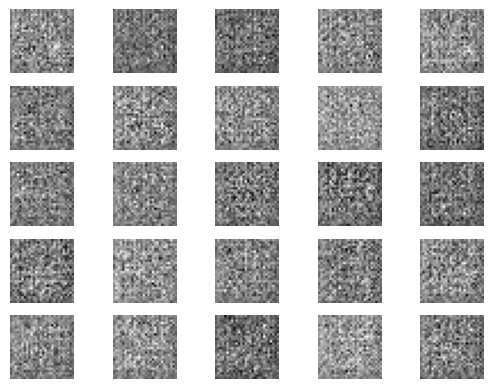

In [25]:
# size of the latent space
latent_dim = 100

# define the discriminator model
model = define_generator(latent_dim)

# generate samples
n_samples = 25
X, _ = generate_fake_samples_from_generator(model, latent_dim, n_samples)

# plot the generated samples
for i in range(n_samples):
 # define subplot
 plt.subplot(5, 5, 1 + i)
 # turn off axis labels
 plt.axis('off')
 # plot single image
 plt.imshow(X[i, :, :, 0], cmap='gray_r')

# show the figure
plt.show()

Running the example generates 25 examples of fake MNIST images and visualizes them on a single plot of 5 by 5 images.

As the model is not trained, the generated images are completely random pixel values in `[0, 1]`. Now that we know how to define and use the generator model, the next step is to train the model.

<a id='sect4'></a>
## <font color='darkblue'>How to Train the Generator Model</font> ([back](#sect0))
<b><font size='3ptx'>The weights in the generator model are updated based on the performance of the discriminator model.</font></b>

<b>When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less</b>.

This defines the zero-sum or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above.

The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

### <font color='darkgreen'>Why would we want to do this?</font>
We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (<font color='brown'>0.3 or 0.5</font>). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (<font color='brown'>i.e. only the weights in the generator</font>) to correct for this error, in turn making the generator better at generating good fake samples.

Let’s make this concrete:
* **Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
* **Outputs**: Binary classification, likelihood the sample is real (<font color='brown'>or fake</font>).

<br/>

The <font color='blue'>define_gan()</font> function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of stochastic gradient descent with the learning rate of 0.0002 and momentum 0.5, recommended when training deep convolutional GANs.

In [26]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

Making the discriminator not trainable is a clever trick in the Keras API.

The <font color='violet'>trainable</font> property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the <font color='blue'>train_on_batch()</font> function.

The discriminator model was then marked as not trainable, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the <font color='blue'>train_on_batch()</font> function. This change in the trainable property does not impact the training of standalone discriminator model.

This behavior is described in the Keras API documentation here:
* [How can I “freeze” Keras layers?](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)

<br/>

The complete example of creating the discriminator, generator, and composite model is listed below:

In [27]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# summarize gan model
gan_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential_4 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


Running the example first creates a summary of the composite model.

We can see that <b>the model expects MNIST images as input and predict a single value as output.</b>

Training the composite model involves generating a batch worth of points in the latent space via the <font color='blue'>generate_latent_points()</font> function in the previous section, and `class=1` labels and calling the <font color='blue'>train_on_batch()</font> function.

The <font color='blue'>train_gan()</font> function below demonstrates this, although is pretty simple as only the generator will be updated each epoch, leaving the discriminator with default model weights:

In [28]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        
        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.

This requires combining elements from the <font color='blue'>train_discriminator()</font> function defined in the discriminator section above and the <font color='blue'>train_gan()</font> function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (<font color='brown'>via the composite model</font>) is listed below. There are a few things to note in this model training function.

First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. <b>We have a dataset size of 60K samples, so with rounding down, there are 234 batches per epoch</b>.

The discriminator model is updated once per batch by combining one half a batch of fake and real examples into a single batch via the [vstack()](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html) NumPy function. You could update the discriminator with each half batch separately (<font color='brown'>recommended for more complex datasets</font>) but combining the samples into a single batch will be faster over a long run, especially when training on GPU hardware.

Finally, <b>we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate</b>.

Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [29]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples_from_generator(g_model, latent_dim, half_batch)
            
            # create training set for the discriminator            
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))

            # update discriminator model weights
            d_loss, _ = d_model.train_on_batch(X, y)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))

            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # summarize loss on this batch
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

We almost have everything we need to develop a GAN for the MNIST handwritten digits dataset.

One remaining aspect is the evaluation of the model.

<a id='sect5'></a>
## <font color='darkblue'>How to Evaluate GAN Model Performance</font> ([back](#sect0))
<b><font size='3ptx'>Generally, there are no objective ways to evaluate the performance of a GAN model.</font></b>

We cannot calculate this objective error score for generated images. It might be possible in the case of MNIST images because the images are so well constrained, but in general, it is not possible (yet).

Instead, images must be subjectively evaluated for quality by a human operator. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.

There are three ways to handle this complex training situation.
1. Periodically evaluate the classification accuracy of the discriminator on real and fake images.
2. Periodically generate many images and save them to file for subjective review.
3. Periodically save the generator model.

All three of these actions can be performed at the same time for a given training epoch, such as every five or 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected and from which specific outputs and models can be cherry-picked for later use.

First, we can define a function called <font color='blue'>summarize_performance()</font> function that will summarize the performance of the discriminator model. It does this by retrieving a sample of real MNIST images, as well as generating the same number of fake MNIST images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample and reporting these scores.

In [30]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)

    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # prepare fake examples
    x_fake, y_fake = generate_fake_samples_from_generator(g_model, latent_dim, n_samples)

    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

This function can be called from the <font color='blue'>train()</font> function based on the current epoch number, such as every 10 epochs:
```python
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
	  ...
	  # evaluate the model performance, sometimes
	  if (i+1) % 10 == 0:
		summarize_performance(i, g_model, d_model, dataset, latent_dim)
```

<br/>

Next, we can update the <font color='blue'>summarize_performance()</font> function to both save the model and to create and save a plot generated examples.

The generator model can be saved by calling the <font color='blue'>save()</font> function on the generator model and providing a unique filename based on the training epoch number.
```python
...
# save the generator model tile file
filename = 'generator_model_%03d.h5' % (epoch + 1)
g_model.save(filename)
```

<br/>

We can develop a function to create a plot of the generated samples.

As we are evaluating the discriminator on 100 generated MNIST images, we can plot all 100 images as a 10 by 10 grid. The ><font color='blue'>save_plot()</font> function below implements this, again saving the resulting plot with a unique filename based on the epoch number.

In [1]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # turn off axis
        plt.axis('off')
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

The updated <font color='blue'>summarize_performance()</font> function with these additions is listed below.

In [2]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)

    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # prepare fake examples
    x_fake, y_fake = generate_fake_samples_from_generator(g_model, latent_dim, n_samples)

    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

    # save plot
    save_plot(x_fake, epoch)

    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

<a id='sect6'></a>
## <font color='darkblue'>Complete Example of GAN for MNIST</font> ([back](#sect0))
<b><font size='3ptx'>We now have everything we need to train and evaluate a GAN on the MNIST handwritten digit dataset.</font></b>

For help on setting up an AWS EC2 instance to run this code, see the tutorial:
* [How to Setup Amazon AWS EC2 GPUs to Train Keras Deep Learning Models (step-by-step)](https://machinelearningmastery.com/develop-evaluate-large-deep-learning-models-keras-amazon-web-services/)

The complete example is listed below:

In [3]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
dataset, _ = load_real_samples()

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20)

NameError: name 'define_discriminator' is not defined

The chosen configuration results in the stable training of both the generative and discriminative model.

The model performance is reported every batch, including the loss of both the discriminative (d) and generative (g) models.

<b><font color='darkred'>Note</font></b>: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision. Consider running the example a few times and compare the average outcome.

The generator is evaluated every 20 epochs, resulting in 10 evaluations, 10 plots of generated images, and 10 saved models.

In this case, we can see that the accuracy fluctuates over training. When viewing the discriminator model’s accuracy score in concert with generated images, we can see that the accuracy on fake examples does not correlate well with the subjective quality of images, but the accuracy for real examples may.

More training, beyond some point, does not mean better quality generated images.

In this case, the results after 10 epochs are low quality, although we can see that the generator has learned to generate centered figures in white on a back background (<font color='brown'>recall we have inverted the grayscale in the plot</font>).
![10 epoch image](images/generated_plot_e010.png)

<br/>


After 20 or 30 more epochs, the model begins to generate very plausible MNIST figures, suggesting that 100 epochs are probably not required for the chosen model configurations:
![10 epoch image](images/generated_plot_e040.png)

<br/>

The generated images after 100 epochs are not greatly different, but I believe I can detect less blocky-ness in the curves:
![10 epoch image](images/generated_plot_e100.png)

<a id='sect7'></a>
## <font color='darkblue'>How to Use the Final Generator Model to Generate Images</font> ([back](#sect0))
<b><font size='3ptx'>Once a final generator model is selected, it can be used in a standalone manner for your application.</font></b>

This involves first loading the model from file, then using it to generate images. The generation of each image requires a point in the latent space as input.

The complete example of loading the saved model and generating images is listed below. In this case, we will use the model saved after 100 training epochs, but the model saved after 40 or 50 epochs would work just as well.

1/1 [==============================] - 0s 131ms/step


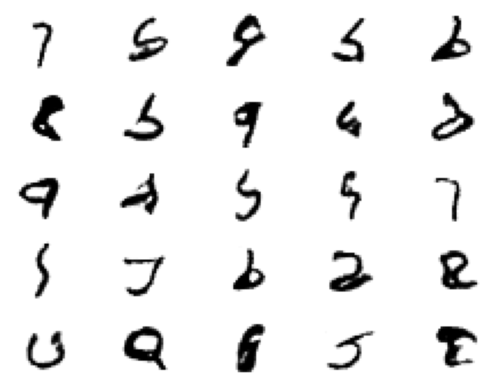

In [35]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)

    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        
        # turn off axis
        plt.axis('off')
        
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

# load model
model = load_model('generator_model_100.h5')

# generate images
latent_points = generate_latent_points(100, 25)

# generate images
X = model.predict(latent_points)

# plot the result
save_plot(X, 5)

Running the example first loads the model, samples 25 random points in the latent space, generates 25 images, then plots the results as a single image. We can see that most of the images are plausible, or plausible pieces of handwritten digits.

The latent space now defines a compressed representation of MNIST handwritten digits.

<b>You can experiment with generating different points in this space and see what types of numbers they generate.</b> The example below generates a single handwritten digit using a vector of all 0.0 values.

1/1 [==============================] - 0s 135ms/step


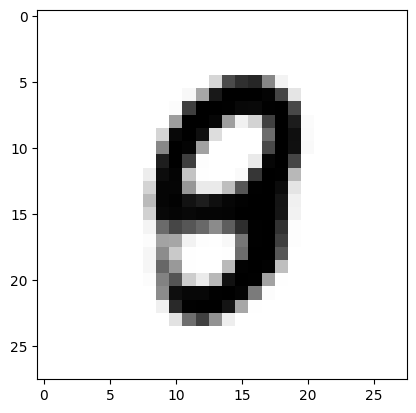

In [36]:
# load model
model = load_model('generator_model_100.h5')

# all 0s
vector = asarray([[0.0 for _ in range(100)]])

# generate image
X = model.predict(vector)

# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()

In this case, a vector of all zeros results in a handwritten 9 or maybe an 8. You can then try navigating the space and see if you can generate a range of similar, but different handwritten digits.

## <font color='darkblue'>Extensions</font>
This section lists some ideas for extending the tutorial that you may wish to explore.
* **TanH Activation and Scaling**: Update the example to use the tanh activation function in the generator and scale all pixel values to the range `[-1, 1]`.
* **Change Latent Space**: Update the example to use a larger or smaller latent space and compare the quality of the results and speed of training.
* **Batch Normalization**: Update the discriminator and/or the generator to make use of batch normalization, recommended for DCGAN models.
* **Label Smoothing**: Update the example to use one-sided label smoothing when training the discriminator, specifically change the target label of real examples from 1.0 to 0.9, and review the effects on image quality and speed of training.
* **Model Configuration**: Update the model configuration to use deeper or more shallow discriminator and/or generator models, perhaps experiment with the [**UpSampling2D**](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) layers in the generator.

## <font color='darkblue'>Supplement</font>
* [RealPython - Generative Adversarial Networks: Build Your First Models (PyTorch)](https://realpython.com/generative-adversarial-networks/)